# Exploring color space

[Roch et al.](https://s3-eu-west-1.amazonaws.com/itempdf74155353254prod/5953606/ChemOS__An_Orchestration_Software_to_Democratize_Autonomous_Discovery_v1.pdf) described an experiment in which they used an autonomous laboratory to explore color space. More specifically, given five colored dyes of unknown color, and a robot that could mix different quantities of up to three of dyes and then measure the color of the result, they sought to identify a combination of dyes that would give a good match to a target color.

We hope to run such experiments in a physical laboratory. First, however, we have two Python functions that will approximate the behavior of a real experiment:

1.   **color_mixture**(c1, f1, c2, f2, c3, f3): Given three RGB colors and their fractions (each ≥0, summing to 1), return the RGB color of the resulting mixture.

2.   **color_diff**(c1, c2): Given two RGB colors, return a measure of the difference between them.

We’ll use these two functions as our experimental laboratory.

Your task is to write a Python program that when given a list of five RGB dyes and a target color will use as few experiments as possible to obtain the combination of three dyes that best approximates the target. We'll evaluate solutions in two ways:

1. The quality of the best color combination found for a specified experiment budget (10 experiments, 100, ...)

2. The number of experiments to find a combination of colors with difference less than a specified threshold

We implement below a naive uniform sampling search. 
It's not too hard to do better than that. Let's see who does the best!

We'll provide details soon on how to submit solutions.

In [ ]:
import imageio
import matplotlib.pyplot as plt
import random

!pip install colormath
# https://python-colormath.readthedocs.io/en/latest/color_objects.html
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import decimal
import itertools

  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39408 sha256=c8a652d26941695512fc8eb159c25c6c90f8d4937389e1618ef4bff31d366bc7
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


## Some utility functions

In [ ]:
red   = sRGBColor(1.0, 0.0, 0.0) #Defines the different colors 
green = sRGBColor(0.0, 1.0, 0.0)
blue  = sRGBColor(0.0, 0.0, 1.0)

def random_color(): # Gets a random color
    color = sRGBColor(random.random(), random.random(), random.random())
    return(color)

def show_colors(colors): # calls function after
    show_colors_at_width(0.5, colors)

def show_colors_at_width(width, colors): #Takes a width and a color to return color image
    num_colors = len(colors)
    size = width/num_colors
    fig, ax = plt.subplots(figsize=(num_colors*width,width))
    ax.plot([0,width], [0,0.2*width], color='w', alpha=0)
    ax.set_xlim([0,width])
    ax.set_ylim([0,size])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(False)

    for c, i in zip(colors, range(num_colors)):
        ax.add_patch( patches.Rectangle((i*size, 0),   size, size, facecolor = c.get_rgb_hex()) )
    plt.show()

In [ ]:
def drange(x, y, jump):
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

## Our experimental lab supports mixing and color differencing

In [ ]:
def combine_colors(color1, f1, color2, f2, color3, f3):
    #if f1<0 or f1>1.0 or f2<0 or f2>1.0 or f3<0 or f3>1.0 or f1+f2+f3!=1.0:
    #    print(f'Bad fractions: {f1}, {f2}, {f3}')
    #    return(-1)
    (r1, g1, b1) = color1.get_value_tuple()
    (r2, g2, b2) = color2.get_value_tuple()
    (r3, g3, b3) = color3.get_value_tuple()
    new_color = sRGBColor(r1*f1 + r2*f2 + r3*f3, g1*f1 + g2*f2 + g3*f3, b1*f1 + b2*f2 + b3*f3)
    return new_color

# See https://dev.to/tejeshreddy/color-difference-between-2-colours-using-python-182b
def color_diff(color1_rgb, color2_rgb):
    color1_lab = convert_color(color1_rgb, LabColor)
    color2_lab = convert_color(color2_rgb, LabColor)
    delta_e = delta_e_cie2000(color1_lab, color2_lab)
    return(delta_e)

## A naive uniform sampling strategy

In [ ]:
def uniform_sampling(target, colors, number):
    best_color = None
    best_diff  = -1
    increment  = 1.0/number
    for [color1, color2, color3] in itertools.combinations(colors, 3):
        for i in drange(0, 1, increment):
            for j in drange(0, 1-i, increment):
                k = 1.0-i-j
                mix  = combine_colors(color1, i, color2, j, color3, k)
                diff = color_diff(target, mix)
                if diff < best_diff or best_diff < 0:
                    best_diff = diff
                    best_color = (mix, color1, i, color2, j, color3, k, mix)
                    #print(f'{round(i,3)}, {round(j,3)}, {round(k,3)} with diff {round(best_diff,3)}')
                
    return(best_diff, best_color)

### A simple example that you can surely improve on: it uses a lot of experiments to find a combination with a difference of 8.3

Target, three colors (0.0, 0.39, 0.61), mix with diff 8.29:


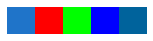

In [ ]:
colors = [red, green, blue]
target = sRGBColor(0.123, 0.456, 0.789)

(best_diff, (best, color1, f1, color2, f2, color3, f3, mix)) = uniform_sampling(target, colors, 100)

print(f'Target, three colors ({round(f1,3)}, {round(f2,3)}, {round(f3,3)}), mix with diff {round(best_diff,2)}:')
show_colors([target, color1, color2, color3, mix])

## Your mission: Implement a better sampling strategy 


## I am using the *SciPy* optimizer module for this task.

In [ ]:
import scipy
from scipy.optimize import minimize

## Constraints on the optimization: 

* The sum of the three ratios has to equal 1
* Each ratio has to be a non-negative number
* Each ratio has to be less than or equal to 1

The constraints are defined below to be passed onto the minimize module

In [ ]:
#Constraints for the optimizer.

constraints = [
        #Constraint 1
        {'type': 'eq', 'fun' : lambda x : (x[0] + x[1] + x[2]) - 1.0}, 

        #Constraint 2 
        {'type': 'ineq', 'fun' : lambda x : x[0]}, 

        {'type': 'ineq', 'fun' : lambda x : x[1]},
        {'type': 'ineq', 'fun' : lambda x : x[2]},

        #Constraint 3 
        {'type': 'ineq', 'fun' : lambda x : 1.0- x[0]},   
        {'type': 'ineq', 'fun' : lambda x : 1.0 - x[1]},
        {'type': 'ineq', 'fun' : lambda x : 1.0 - x[2]},
]


##Objective/Loss function:

In [ ]:
# Takes in the colors (tuple) to be mixed and their ratios (array), and compares it to the target color (sRGBColor object) through color_diff method
def objective_func(mixing_ratios, mixing_colors, target):
  combination = combine_colors(mixing_colors[0], mixing_ratios[0], mixing_colors[1], mixing_ratios[1], mixing_colors[2], mixing_ratios[2])
  difference = color_diff(combination, target)
  return difference

##Optimization Loop for Part 1

In [ ]:
def optimization_loop_part_one(target, colors, maximum_iterations):
  '''
  Takes:
    Target color
    Five colors to mix
    Maximum number of iterations to go through

  Returns:
    Distance between target color and best color the method found
    Best triplet colors and their ratios
    Best color that's compared to the target
    Number of iterations it took to find the best color

  '''

  best_triplet_iters = 0
  total_iters = 0 
  best_diff = -1
  best_colors = None
  best_ratios = None

  for [color1, color2 ,color3] in itertools.combinations(colors, 3):
    #initial dummy guess. 
    initial_ratios = [random.random(), random.random(), random.random()]

    #call to the scipy.optimize.minimize function to use the Sequential Least Squares algorithm.
    result = minimize(objective_func,
                      initial_ratios,
                      args=([color1, color2, color3], target), 
                      constraints = constraints, 
                      method='SLSQP', #Sequential Least Squares
                      options = {'maxiter': maximum_iterations/6})
    

    #If this triplet mixes closest to the target, then they are the best triplet. 
    if result.fun < best_diff or best_diff == -1 :
      best_diff = result.fun  
      best_colors = [color1, color2, color3]
      best_ratios = result.x 
      best_triplet_iters = result.nfev

    total_iters += result.nfev


  return (best_diff, (best_colors[0], best_ratios[0],
                      best_colors[1], best_ratios[1],
                      best_colors[2], best_ratios[2]), 
          
                      combine_colors(
                          best_colors[0], best_ratios[0],
                          best_colors[1], best_ratios[1],
                          best_colors[2], best_ratios[2]), 
          
          best_triplet_iters)

## Another test to try: Use a random set of colors

Available colors:


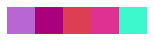

Target, three colors (0.937, 0.0, 0.063), mix with difference 11.36:


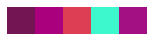

In [ ]:
colors = [random_color(), random_color(), random_color(), random_color(), random_color()]
target = random_color()

print('Available colors:')
show_colors(colors)

(best_diff, (color1, f1, color2, f2, color3, f3), mix, iters) = optimization_loop_part_one(target, colors, 100)

print(f'Target, three colors ({round(f1,3)}, {round(f2,3)}, {round(f3,3)}), mix with difference {round(best_diff,2)}:')
show_colors([target, color1, color2, color3, mix])

##Part 1: Finding the best color in N iterations

In [ ]:
def task_one_wrapper(max_iter, num_experiments_to_average):
  my_best_distances = []
  benchmark_distances = []
  my_iteration_count = []
  benchmark_iteration_count = []

  for i in range(num_experiments_to_average):
    print(f"Experiment {i+1}  \n")

    random.seed(i*10)
    color_options = [random_color(), random_color(), random_color(), random_color(), random_color()]
    target_color = random_color()

    print('Available 5 colors:')
    show_colors(color_options)

    best_diff, triplet_and_ratios, best_mix, num_iters = optimization_loop_part_one(target_color, color_options, max_iter)
    my_best_distances.append(best_diff)
    my_iteration_count.append(num_iters)

    print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
    print(f'Best difference: {round(best_diff,3)} ')
    print(f'Number of iterations: {num_iters}')
    print(f'Plot: target color, three best colors, closest mix (result)' )
    show_colors([target_color, triplet_and_ratios[0], triplet_and_ratios[2], triplet_and_ratios[4], best_mix])

    print('--------------------------------')

## Experiment Budget : 10 

Experiment 1  

Available 5 colors:


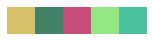

Optimum mix ratios -0.0, 0.116, 0.884 
Best difference: 20.884 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


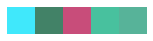

--------------------------------
Experiment 2  

Available 5 colors:


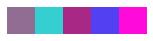

Optimum mix ratios 1.0, -0.0, 0.0 
Best difference: 25.549 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


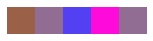

--------------------------------
Experiment 3  

Available 5 colors:


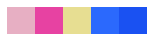

Optimum mix ratios 0.079, 0.557, 0.062 
Best difference: 10.316 
Number of iterations: 12
Plot: target color, three best colors, closest mix (result)


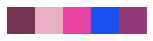

--------------------------------
Experiment 4  

Available 5 colors:


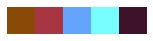

Optimum mix ratios 0.496, 0.619, 0.484 
Best difference: 7.972 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


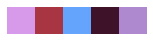

--------------------------------
Experiment 5  

Available 5 colors:


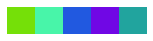

Optimum mix ratios 1.0, 0.0, -0.0 
Best difference: 4.805 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


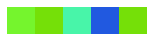

--------------------------------
Experiment 6  

Available 5 colors:


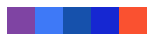

Optimum mix ratios 0.475, 0.393, 0.618 
Best difference: 7.194 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


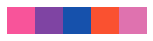

--------------------------------
Experiment 7  

Available 5 colors:


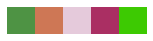

Optimum mix ratios 0.0, 1.0, 0.0 
Best difference: 11.014 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


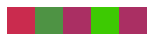

--------------------------------
Experiment 8  

Available 5 colors:


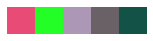

Optimum mix ratios 0.25, 0.359, 0.891 
Best difference: 31.648 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


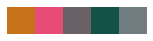

--------------------------------
Experiment 9  

Available 5 colors:


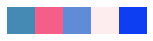

Optimum mix ratios 0.116, 0.588, 0.045 
Best difference: 15.704 
Number of iterations: 11
Plot: target color, three best colors, closest mix (result)


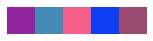

--------------------------------
Experiment 10  

Available 5 colors:


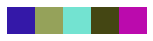

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 20.59 
Number of iterations: 10
Plot: target color, three best colors, closest mix (result)


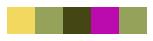

--------------------------------


In [ ]:
task_one_wrapper(10, 10)

##Experiment budget: 100

Experiment 1  

Available 5 colors:


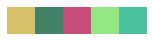

Optimum mix ratios 0.0, 0.088, 0.912 
Best difference: 20.861 
Number of iterations: 22
Plot: target color, three best colors, closest mix (result)


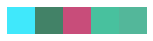

--------------------------------
Experiment 2  

Available 5 colors:


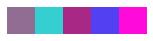

Optimum mix ratios 1.0, 0.0, -0.0 
Best difference: 25.549 
Number of iterations: 15
Plot: target color, three best colors, closest mix (result)


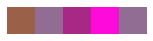

--------------------------------
Experiment 3  

Available 5 colors:


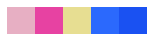

Optimum mix ratios 0.741, 0.0, 0.259 
Best difference: 21.952 
Number of iterations: 26
Plot: target color, three best colors, closest mix (result)


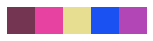

--------------------------------
Experiment 4  

Available 5 colors:


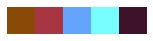

Optimum mix ratios 0.49, 0.001, 0.509 
Best difference: 16.066 
Number of iterations: 41
Plot: target color, three best colors, closest mix (result)


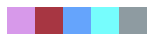

--------------------------------
Experiment 5  

Available 5 colors:


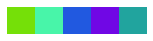

Optimum mix ratios 0.747, 0.253, -0.0 
Best difference: 3.703 
Number of iterations: 31
Plot: target color, three best colors, closest mix (result)


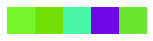

--------------------------------
Experiment 6  

Available 5 colors:


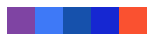

Optimum mix ratios 0.0, 0.349, 0.651 
Best difference: 12.57 
Number of iterations: 37
Plot: target color, three best colors, closest mix (result)


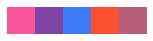

--------------------------------
Experiment 7  

Available 5 colors:


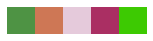

Optimum mix ratios 0.372, 0.628, -0.0 
Best difference: 5.626 
Number of iterations: 32
Plot: target color, three best colors, closest mix (result)


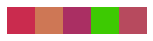

--------------------------------
Experiment 8  

Available 5 colors:


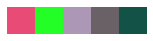

Optimum mix ratios 0.701, 0.299, -0.0 
Best difference: 11.709 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


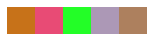

--------------------------------
Experiment 9  

Available 5 colors:


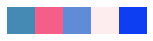

Optimum mix ratios 0.564, 0.0, 0.436 
Best difference: 9.212 
Number of iterations: 47
Plot: target color, three best colors, closest mix (result)


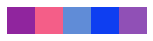

--------------------------------
Experiment 10  

Available 5 colors:


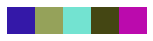

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 20.59 
Number of iterations: 22
Plot: target color, three best colors, closest mix (result)


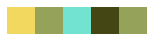

--------------------------------


In [ ]:
task_one_wrapper(100, 10)

## Experiment budget: 200

Experiment 1  

Available 5 colors:


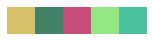

Optimum mix ratios 0.0, 0.088, 0.912 
Best difference: 20.861 
Number of iterations: 22
Plot: target color, three best colors, closest mix (result)


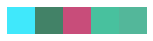

--------------------------------
Experiment 2  

Available 5 colors:


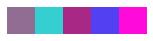

Optimum mix ratios 1.0, 0.0, -0.0 
Best difference: 25.549 
Number of iterations: 15
Plot: target color, three best colors, closest mix (result)


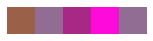

--------------------------------
Experiment 3  

Available 5 colors:


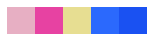

Optimum mix ratios 0.741, 0.0, 0.259 
Best difference: 21.952 
Number of iterations: 26
Plot: target color, three best colors, closest mix (result)


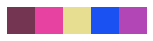

--------------------------------
Experiment 4  

Available 5 colors:


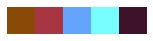

Optimum mix ratios 0.49, 0.001, 0.509 
Best difference: 16.066 
Number of iterations: 41
Plot: target color, three best colors, closest mix (result)


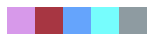

--------------------------------
Experiment 5  

Available 5 colors:


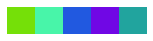

Optimum mix ratios 0.747, 0.253, -0.0 
Best difference: 3.703 
Number of iterations: 31
Plot: target color, three best colors, closest mix (result)


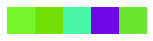

--------------------------------
Experiment 6  

Available 5 colors:


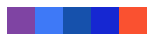

Optimum mix ratios 0.0, 0.349, 0.651 
Best difference: 12.57 
Number of iterations: 37
Plot: target color, three best colors, closest mix (result)


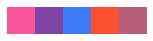

--------------------------------
Experiment 7  

Available 5 colors:


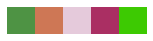

Optimum mix ratios 0.372, 0.628, -0.0 
Best difference: 5.626 
Number of iterations: 32
Plot: target color, three best colors, closest mix (result)


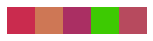

--------------------------------
Experiment 8  

Available 5 colors:


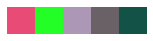

Optimum mix ratios 0.701, 0.299, -0.0 
Best difference: 11.709 
Number of iterations: 38
Plot: target color, three best colors, closest mix (result)


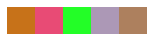

--------------------------------
Experiment 9  

Available 5 colors:


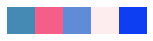

Optimum mix ratios 0.564, 0.0, 0.436 
Best difference: 9.212 
Number of iterations: 47
Plot: target color, three best colors, closest mix (result)


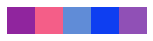

--------------------------------
Experiment 10  

Available 5 colors:


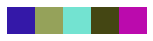

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 20.59 
Number of iterations: 22
Plot: target color, three best colors, closest mix (result)


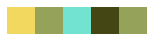

--------------------------------


In [ ]:
task_one_wrapper(200, 10)

##Part 2: Number of Iterations Needed to Reach a Specified Threshold of Distance

In [ ]:
def is_threshold_met(xk, state):
  '''
  Callback method passed to the scipy.optimize.minimize function.
  Stops the execution of the optimization loop once the threshold is met.
  state object is passed to this function by the minimize function.
  state.fun holds the current value of the objective function that is being minimized.
  '''

  #If the color distance reached below the threshold, then stop execution.
  if(state.fun <= THRESHOLD):
    return True


In [ ]:
#Optimization loop. 
def optimization_loop_part_two(target, colors):
    best_diff = -1  
    best_colors = None
    best_ratios = None
    iters = 0

    for [c1, c2, c3] in itertools.combinations(colors, 3): 
      #initial dummy guess. 
      initial_ratios = [random.random(), random.random(), random.random()]

      #Using the Trust Regions Method from SciPy Optimize module because this is the only method that can take a callback.
      #Callback stops the optimization (distance minimization) when the call returns True, which it does when the objective function...
      #...returns a value below the threshold.

      result = minimize(objective_func,
                      initial_ratios,
                      args=([color1, color2, color3], target), 
                      constraints = constraints, 
                      method='trust-constr', #Trust Regions Method
                      callback= is_threshold_met)
      
      if (result.fun < best_diff or best_diff == -1):
        best_diff = result.fun
        best_colors = [c1, c2, c3]
        best_ratios = result.x
        iters = result.nfev # iterations it took to satisfy the contion.

        

    return ( best_diff, (best_colors[0], best_ratios[0],
                         best_colors[1], best_ratios[1],
                         best_colors[2], best_ratios[2]),
            
                         combine_colors(best_colors[0], best_ratios[0],
                                        best_colors[1], best_ratios[1], 
                                        best_colors[2], best_ratios[2]) , 
            
            iters)

In [ ]:
import numpy as np
def task_two_wrapper(num_experiments_to_average):
  
  my_best_distances = []
  my_iteration_count = []

  for i in range(num_experiments_to_average):
    print(f"Experiment {i+1}  \n")
    color_options = [random_color(), random_color(), random_color(), random_color(), random_color()]
    target_color = random_color()

    print('Available 5 colors:')
    show_colors(color_options)

    best_diff, triplet_and_ratios, best_mix, num_iters = optimization_loop_part_two(target_color, color_options)
    my_best_distances.append(best_diff)
    my_iteration_count.append(num_iters)

    if(round(best_diff, 3) <= THRESHOLD):
      print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
      print(f'Best difference: {round(best_diff,3)}')
      print(f'Satisfied threshold after {num_iters} of iterations!')
    
    else:
      print(f'Optimum mix ratios {round(triplet_and_ratios[1], 3)}, {round(triplet_and_ratios[3],3)}, {round(triplet_and_ratios[5], 3)} ')
      print(f'Best difference: {round(best_diff,3)} ')
      print(f'Failed to meet the threshold with the given colors. Attemps: {num_iters}')


    print(f'Plot: target color, three best colors, closest mix (result)' )
    show_colors([target_color, triplet_and_ratios[0], triplet_and_ratios[2], triplet_and_ratios[4], best_mix])

    print('--------------------------------')

## Easy Case: Threshold = 100.0

Experiment 1  

Available 5 colors:


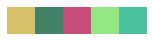

Optimum mix ratios 0.87, 0.191, 0.568 
Best difference: 18.513
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


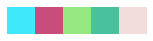

--------------------------------
Experiment 2  

Available 5 colors:


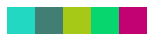

Optimum mix ratios 0.222, 0.438, 0.496 
Best difference: 31.046
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


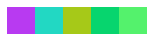

--------------------------------
Experiment 3  

Available 5 colors:


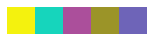

Optimum mix ratios 0.999, 0.674, 0.182 
Best difference: 23.571
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


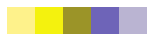

--------------------------------
Experiment 4  

Available 5 colors:


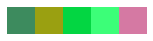

Optimum mix ratios 0.386, 0.351, 0.585 
Best difference: 26.11
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


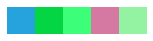

--------------------------------
Experiment 5  

Available 5 colors:


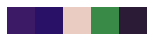

Optimum mix ratios 0.672, 0.506, 0.178 
Best difference: 19.239
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


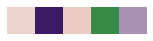

--------------------------------
Experiment 6  

Available 5 colors:


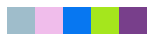

Optimum mix ratios 0.16, 0.797, 0.139 
Best difference: 24.242
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


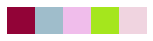

--------------------------------
Experiment 7  

Available 5 colors:


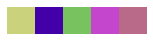

Optimum mix ratios 0.361, 0.602, 0.304 
Best difference: 30.502
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


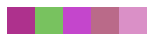

--------------------------------
Experiment 8  

Available 5 colors:


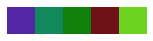

Optimum mix ratios 0.586, 0.453, 0.3 
Best difference: 25.82
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


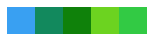

--------------------------------
Experiment 9  

Available 5 colors:


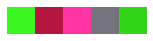

Optimum mix ratios 0.582, 0.142, 0.064 
Best difference: 36.211
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


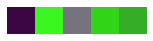

--------------------------------
Experiment 10  

Available 5 colors:


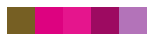

Optimum mix ratios 0.267, 0.21, 0.281 
Best difference: 18.608
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


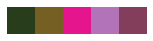

--------------------------------


In [ ]:
THRESHOLD = 100.0
task_two_wrapper(10)

## Medium Case: Threshold = 20.0

Experiment 1  

Available 5 colors:


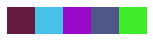

Optimum mix ratios 0.052, 0.621, 0.026 
Best difference: 16.097
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


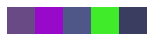

--------------------------------
Experiment 2  

Available 5 colors:


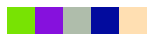

Optimum mix ratios 0.052, 0.954, -0.009 
Best difference: 17.304
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


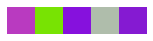

--------------------------------
Experiment 3  

Available 5 colors:


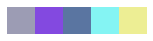

Optimum mix ratios 0.466, -0.045, 0.62 
Best difference: 19.533
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


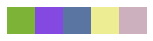

--------------------------------
Experiment 4  

Available 5 colors:


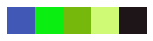

Optimum mix ratios 0.0, 0.797, 0.203 
Best difference: 20.907 
Failed to meet the threshold with the given colors. Attemps: 164
Plot: target color, three best colors, closest mix (result)


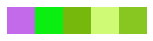

--------------------------------
Experiment 5  

Available 5 colors:


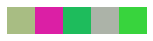

Optimum mix ratios 0.39, 0.0, 0.61 
Best difference: 20.199 
Failed to meet the threshold with the given colors. Attemps: 224
Plot: target color, three best colors, closest mix (result)


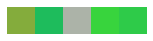

--------------------------------
Experiment 6  

Available 5 colors:


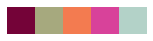

Optimum mix ratios 0.395, 0.605, 0.0 
Best difference: 27.429 
Failed to meet the threshold with the given colors. Attemps: 68
Plot: target color, three best colors, closest mix (result)


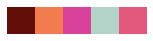

--------------------------------
Experiment 7  

Available 5 colors:


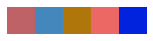

Optimum mix ratios 0.168, 0.0, 0.832 
Best difference: 22.232 
Failed to meet the threshold with the given colors. Attemps: 64
Plot: target color, three best colors, closest mix (result)


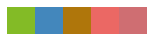

--------------------------------
Experiment 8  

Available 5 colors:


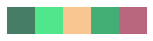

Optimum mix ratios 0.461, -0.063, 0.619 
Best difference: 18.952
Satisfied threshold after 12 of iterations!
Plot: target color, three best colors, closest mix (result)


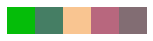

--------------------------------
Experiment 9  

Available 5 colors:


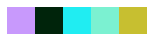

Optimum mix ratios 0.0, 0.689, 0.311 
Best difference: 24.383 
Failed to meet the threshold with the given colors. Attemps: 292
Plot: target color, three best colors, closest mix (result)


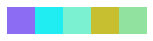

--------------------------------
Experiment 10  

Available 5 colors:


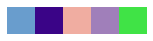

Optimum mix ratios 0.0, 0.0, 1.0 
Best difference: 34.808 
Failed to meet the threshold with the given colors. Attemps: 48
Plot: target color, three best colors, closest mix (result)


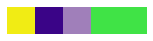

--------------------------------


In [ ]:
THRESHOLD = 20.0
task_two_wrapper(10)

## Hard Case: Threshold = 10.0

Experiment 1  

Available 5 colors:


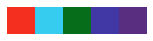

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Optimum mix ratios 0.125, 0.452, 0.422 
Best difference: 31.538 
Failed to meet the threshold with the given colors. Attemps: 4000
Plot: target color, three best colors, closest mix (result)


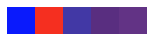

--------------------------------
Experiment 2  

Available 5 colors:


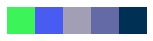

Optimum mix ratios 0.809, -0.092, 0.349 
Best difference: 7.109
Satisfied threshold after 8 of iterations!
Plot: target color, three best colors, closest mix (result)


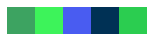

--------------------------------
Experiment 3  

Available 5 colors:


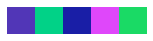

Optimum mix ratios 0.641, 0.359, 0.0 
Best difference: 24.96 
Failed to meet the threshold with the given colors. Attemps: 264
Plot: target color, three best colors, closest mix (result)


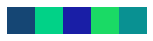

--------------------------------
Experiment 4  

Available 5 colors:


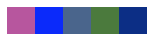

Optimum mix ratios 0.061, 0.008, 0.394 
Best difference: 6.583
Satisfied threshold after 4 of iterations!
Plot: target color, three best colors, closest mix (result)


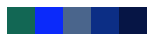

--------------------------------
Experiment 5  

Available 5 colors:


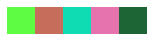

Optimum mix ratios 0.0, 0.0, 1.0 
Best difference: 22.553 
Failed to meet the threshold with the given colors. Attemps: 48
Plot: target color, three best colors, closest mix (result)


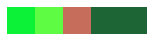

--------------------------------
Experiment 6  

Available 5 colors:


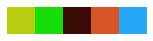

Optimum mix ratios 0.0, 0.0, 1.0 
Best difference: 16.639 
Failed to meet the threshold with the given colors. Attemps: 44
Plot: target color, three best colors, closest mix (result)


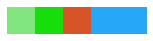

--------------------------------
Experiment 7  

Available 5 colors:


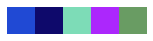

Optimum mix ratios 1.0, 0.0, 0.0 
Best difference: 13.973 
Failed to meet the threshold with the given colors. Attemps: 48
Plot: target color, three best colors, closest mix (result)


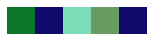

--------------------------------
Experiment 8  

Available 5 colors:


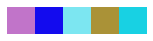

Optimum mix ratios 0.0, 0.423, 0.577 
Best difference: 26.088 
Failed to meet the threshold with the given colors. Attemps: 180
Plot: target color, three best colors, closest mix (result)


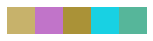

--------------------------------
Experiment 9  

Available 5 colors:


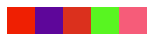

Optimum mix ratios 0.0, 0.0, 1.0 
Best difference: 18.129 
Failed to meet the threshold with the given colors. Attemps: 48
Plot: target color, three best colors, closest mix (result)


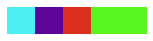

--------------------------------
Experiment 10  

Available 5 colors:


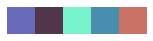

Optimum mix ratios 0.475, 0.451, 0.074 
Best difference: 23.756 
Failed to meet the threshold with the given colors. Attemps: 3960
Plot: target color, three best colors, closest mix (result)


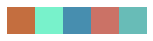

--------------------------------


In [ ]:
THRESHOLD = 10.0
task_two_wrapper(10)

## Comments on the assignment

*  A possible extension is to learn the response function of the sensor
*  You may consider an explore/exploit strategy



